***Target Trial Emulation in R***

**by Alan Yang**

**Converted to Python by: Laurenz Mesiah A. Palanas & Emily Rose Escartin**

This tutorial demonstrates how to implement Target Trial Emulation in Python, converting the workflow from the R TrialEmulation package. Target Trial Emulation is a framework for using observational data to emulate randomized controlled trials, which helps estimate causal effects when randomized trials are impractical or unethical.
Let's start by creating a Python implementation that follows the same 9 steps as the original R code.

***1. Setup***

- Define trial estimands

In [ ]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pickle
from scipy.stats import norm


# Define helper function to create directories
def create_save_directory(save_path):
    """Create directory for saving models if it doesn't exist."""
    if save_path:
        Path(save_path).mkdir(parents=True, exist_ok=True)

# Class definition for TrialSequence
class TrialSequence:
    def __init__(self, estimand="ITT"):
        self.estimand = estimand
        self.data = None
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_event_col = None
        self.switch_weight_models = None
        self.censor_weight_models = None
        self.expanded_data = None
        self.outcome_model = None
        self.model_summary = None
        self.loaded_data = None
        self.adjustment_terms = None
        self.expansion_options = {
            "chunk_size": 500,
            "censor_at_switch": True if estimand == "PP" else False,
            "first_period": 0,
            "last_period": float('inf')
        }

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        self.data = data
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        return self

***Step 2: Data Preparation***
- Load observational data

In [12]:
data_censored = pd.read_csv("data/data_censored.csv")
data_censored.head()

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


In [15]:
# Initialize TrialSequence objects
trial_pp = TrialSequence(estimand="PP").set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")
trial_itt = TrialSequence(estimand="ITT").set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")

***Step 3: Weight Models and Censoring***

we define Inverse Probability of Treatment Switching Weights (IPSW) to adjust for cases where individuals switch treatments during the study. This adjustment is necessary in Per-Protocol (PP) analyses, where we aim to estimate the effect of staying on the assigned treatment rather than allowing deviations.

In [16]:
### 3.1 Censoring Due to Treatment Switching

def set_switch_weight_model(self, numerator, denominator, save_path=None):
    """Set models for treatment switching weights."""
    if self.estimand != "PP":
        print("Warning: Switch weight models are only used for PP estimand")
        return self
    
    create_save_directory(save_path)
    self.switch_weight_models = {
        "numerator": numerator,
        "denominator": denominator,
        "save_path": save_path,
        "fitted": False
    }
    print(f"\n##  - Numerator formula: treatment ~ {numerator}")
    print(f"##  - Denominator formula: treatment ~ {denominator}")
    print("##  - Model fitter type: statsmodels GLM (logit)")
    print("##  - Weight models not fitted. Use calculate_weights()")
    return self

TrialSequence.set_switch_weight_model = set_switch_weight_model

trial_pp.set_switch_weight_model(numerator="age", denominator="age + x1 + x3", save_path="trial_pp_switch_models")


##  - Numerator formula: treatment ~ age
##  - Denominator formula: treatment ~ age + x1 + x3
##  - Model fitter type: statsmodels GLM (logit)
##  - Weight models not fitted. Use calculate_weights()


***3.2 Other Informative Censoring***

- In this step, we define Inverse Probability of Censoring Weights (IPCW) to adjust for informative censoring. Censoring occurs when participants drop out of the study or their follow-up is cut short before experiencing the event of interest. If censoring is related to factors that also influence survival, failing to account for it can introduce bias.

In [17]:

def set_censor_weight_model(self, censor_event, numerator, denominator, pool_models="none", save_path=None):
    """Set models for censoring weights."""
    create_save_directory(save_path)
    self.censor_event_col = censor_event
    self.censor_weight_models = {
        "numerator": numerator,
        "denominator": denominator,
        "pool_models": pool_models,
        "save_path": save_path,
        "fitted": False
    }
    print(f"\n##  - Numerator formula: 1 - {censor_event} ~ {numerator}")
    print(f"##  - Denominator formula: 1 - {censor_event} ~ {denominator}")
    if pool_models != "none":
        print(f"##  - Numerator model is pooled across treatment arms.")
    print("##  - Model fitter type: statsmodels GLM (logit)")
    print("##  - Weight models not fitted. Use calculate_weights()")
    return self

TrialSequence.set_censor_weight_model = set_censor_weight_model

trial_pp.set_censor_weight_model(censor_event="censored", numerator="x2", denominator="x2 + x1", save_path="trial_pp_switch_models")
trial_itt.set_censor_weight_model(censor_event="censored", numerator="x2", denominator="x2 + x1", pool_models="numerator", save_path="trial_itt_switch_models")


##  - Numerator formula: 1 - censored ~ x2
##  - Denominator formula: 1 - censored ~ x2 + x1
##  - Model fitter type: statsmodels GLM (logit)
##  - Weight models not fitted. Use calculate_weights()

##  - Numerator formula: 1 - censored ~ x2
##  - Denominator formula: 1 - censored ~ x2 + x1
##  - Numerator model is pooled across treatment arms.
##  - Model fitter type: statsmodels GLM (logit)
##  - Weight models not fitted. Use calculate_weights()


***Step 4: Calculate Weights***

- In this step, we fit the individual weight models and compute inverse probability weights (IPW) for both **censoring** and **treatment switching**. These weights adjust for potential biases introduced by informative censoring and deviations from assigned treatment. 


In [22]:
## Step 4: Calculate Weights

# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import joblib
import os

# Create directory to store models
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save model function
def save_model(model, name):
    """Save the logistic regression model to disk."""
    path = os.path.join(MODEL_DIR, f"{name}.pkl")
    joblib.dump(model, path)
    return path

# Ensure TrialSequence class is defined before adding methods
class TrialSequence:
    def __init__(self, estimand="ITT"):
        self.estimand = estimand
        self.data = None
        self.censor_event_col = None
        self.switch_weight_models = None
        self.censor_weight_models = None
    
    def set_data(self, data, censor_event_col):
        """Set the dataset and key column names."""
        self.data = data
        self.censor_event_col = censor_event_col
        return self

    def calculate_weights(self):
        """Calculate censoring and treatment switching weights."""
        print("\n=== Step 4: Calculating Weights ===")
        
        # Initialize weights
        print("Initializing weight columns...")
        self.data["wt"] = 1.0  # Treatment switching weights
        self.data["wtC"] = 1.0  # Censoring weights
        
        # Fit and apply censoring weight models
        if self.censor_weight_models:
            print("\nFitting censoring weight models...")
            self._fit_censor_weight_models()
            print("Applying censoring weights...")
            self._apply_censor_weights()
        
        # Fit and apply treatment switching weight models if PP estimand
        if self.switch_weight_models and self.estimand == "PP":
            print("\nFitting treatment switching weight models...")
            self._fit_switch_weight_models()
            print("Applying treatment switching weights...")
            self._apply_switch_weights()
        
        print("\n✅ Weight calculation completed.")
        return self

    def _fit_censor_weight_models(self):
        """Fit logistic regression models for censoring weights."""
        if not self.censor_weight_models:
            print("No censoring weight models specified.")
            return

        print("Fitting censoring weight models...")
        models = {}

        # Numerator Model: P(censor_event = 0 | X)
        formula_num = f"1 - {self.censor_event_col} ~ {self.censor_weight_models['numerator']}"
        models["n"] = smf.glm(formula=formula_num, data=self.data, family=sm.families.Binomial()).fit()

        # Denominator Model: P(censor_event = 0 | X, previous treatment)
        formula_denom = f"1 - {self.censor_event_col} ~ {self.censor_weight_models['denominator']}"
        models["d"] = smf.glm(formula=formula_denom, data=self.data, family=sm.families.Binomial()).fit()

        self.censor_weight_models["models"] = models
        self.censor_weight_models["fitted"] = True
        print("✅ Censoring weight models fitted successfully.")

    def _apply_censor_weights(self):
        """Apply inverse probability of censoring weights (IPCW)."""
        if not self.censor_weight_models or not self.censor_weight_models.get("fitted"):
            print("Censoring weight models not fitted. Run `calculate_weights()` first.")
            return

        print("Applying censoring weights to dataset...")
        num_model = self.censor_weight_models["models"]["n"]
        denom_model = self.censor_weight_models["models"]["d"]

        # Compute probabilities
        num_probs = num_model.predict(self.data)
        denom_probs = denom_model.predict(self.data)

        # Compute inverse probability weights
        self.data["wtC"] = num_probs / denom_probs
        print("✅ Censoring weights applied successfully.")


# Initialize objects
trial_pp = TrialSequence(estimand="PP").set_data(data_censored, "censored")
trial_itt = TrialSequence(estimand="ITT").set_data(data_censored, "censored")

# Compute weights for ITT and PP trials
print("Computing weights for per-protocol (PP) analysis...")
trial_pp.calculate_weights()
print("\nComputing weights for intention-to-treat (ITT) analysis...")
trial_itt.calculate_weights()



Computing weights for per-protocol (PP) analysis...

=== Step 4: Calculating Weights ===
Initializing weight columns...

✅ Weight calculation completed.

Computing weights for intention-to-treat (ITT) analysis...

=== Step 4: Calculating Weights ===
Initializing weight columns...

✅ Weight calculation completed.


In [25]:
# Display computed data
print("\n=== Displaying Computed Data for PP Analysis ===")
print(trial_pp.data.head())



=== Displaying Computed Data for PP Analysis ===
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible   wt  wtC  
0         0         1  1.0  1.0  
1         0         0  1.0  1.0  
2         0         0  1.0  1.0  
3         0         0  1.0  1.0  
4         0         0  1.0  1.0  


In [26]:
print("\n=== Displaying Computed Data for ITT Analysis ===")
print(trial_itt.data.head())


=== Displaying Computed Data for ITT Analysis ===
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible   wt  wtC  
0         0         1  1.0  1.0  
1         0         0  1.0  1.0  
2         0         0  1.0  1.0  
3         0         0  1.0  1.0  
4         0         0  1.0  1.0  


***Step 5: Specify Outcome Model***
- we define the statistical model that will estimate treatment effects on the outcome. The outcome model is essential for analyzing how treatment influences survival while adjusting for potential confounders.

In [27]:
# Define method to set the outcome model in TrialSequence class
def set_outcome_model(self, adjustment_terms=None):
    """Specify the outcome model with optional adjustment terms."""
    print("\n=== Step 5: Specifying Outcome Model ===")
    
    # Store adjustment terms if provided
    self.adjustment_terms = adjustment_terms
    
    if adjustment_terms:
        print(f"Outcome model includes adjustment terms: {adjustment_terms}")
    else:
        print("Outcome model set with default terms (stabilized weight model numerator).")
    
    return self

# Attach method to TrialSequence class
TrialSequence.set_outcome_model = set_outcome_model

# Specify outcome models for PP and ITT trials
trial_pp.set_outcome_model()
trial_itt.set_outcome_model(adjustment_terms="x2")



=== Step 5: Specifying Outcome Model ===
Outcome model set with default terms (stabilized weight model numerator).

=== Step 5: Specifying Outcome Model ===
Outcome model includes adjustment terms: x2


***Step 6: Expand Trials***
- we prepare the dataset for analysis by creating a sequence of target trials. This ensures that each individual’s data is structured correctly, capturing treatment assignments and follow-up times in a way that allows for proper causal inference.

In [28]:
# Define method to set expansion options in TrialSequence class
def set_expansion_options(self, chunk_size=500, censor_at_switch=True, first_period=0, last_period=float('inf')):
    """Set options for expanding trials into a sequence of target trials."""
    print("\n=== Step 6: Setting Expansion Options ===")
    
    self.expansion_options = {
        "chunk_size": chunk_size,
        "censor_at_switch": censor_at_switch if self.estimand == "PP" else False,
        "first_period": first_period,
        "last_period": last_period
    }
    
    print(f"Chunk size: {chunk_size}")
    print(f"Censor at switch: {self.expansion_options['censor_at_switch']}")
    print(f"First period: {first_period} | Last period: {last_period}")
    
    return self

# Attach method to TrialSequence class
TrialSequence.set_expansion_options = set_expansion_options

# Set expansion options for PP and ITT trials
trial_pp.set_expansion_options()
trial_itt.set_expansion_options()


=== Step 6: Setting Expansion Options ===
Chunk size: 500
Censor at switch: True
First period: 0 | Last period: inf

=== Step 6: Setting Expansion Options ===
Chunk size: 500
Censor at switch: False
First period: 0 | Last period: inf


In [40]:
# Define method to expand trials in TrialSequence class
def expand_trials(self):
    """Expand observational data into a sequence of target trials."""
    print("\n=== Step 6.1: Expanding Sequence of Trials Data ===")
    
    # Ensure required attributes exist before proceeding
    if not hasattr(self, "period_col") or not hasattr(self, "treatment_col"):
        raise AttributeError("Missing required attributes. Ensure set_data() is called before expand_trials().")
    
    # Placeholder for expansion logic
    self.expanded_data = self.data.copy()
    self.expanded_data["trial_period"] = self.expanded_data[self.period_col] - self.expansion_options["first_period"]
    self.expanded_data["followup_time"] = self.expanded_data[self.period_col]
    self.expanded_data["assigned_treatment"] = self.expanded_data[self.treatment_col]
    
    print("✅ Expansion completed.")
    print(f"Dataset contains {len(self.expanded_data)} observations.")
    
    return self



# Modify set_data() to accept necessary parameters
def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
    """Set the dataset and key column names."""
    self.data = data
    self.id_col = id_col
    self.period_col = period_col
    self.treatment_col = treatment_col
    self.outcome_col = outcome_col
    self.eligible_col = eligible_col
    return self

# Attach method to TrialSequence class
TrialSequence.set_data = set_data

# Ensure set_data() assigns all necessary attributes
trial_pp.set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")
trial_itt.set_data(data_censored, "id", "period", "treatment", "outcome", "eligible")

# Expand trials for PP and ITT
trial_pp.expand_trials()
trial_itt.expand_trials()

# Display expanded data
print("\n=== Displaying Expanded Trials Data for PP Analysis ===")
print(trial_pp.expanded_data.head())
print("\n=== Displaying Expanded Trials Data for ITT Analysis ===")
print(trial_itt.expanded_data.head())



=== Step 6.1: Expanding Sequence of Trials Data ===
✅ Expansion completed.
Dataset contains 725 observations.

=== Step 6.1: Expanding Sequence of Trials Data ===
✅ Expansion completed.
Dataset contains 725 observations.

=== Displaying Expanded Trials Data for PP Analysis ===
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible   wt  wtC  trial_period  followup_time  \
0         0         1  1.0  1.0             0              0   
1         0         0  1.0  1.0             1              1   
2         0         0  1.0  1.0             2   

***Step 7: Load or Sample from Expanded Data***

- In this step, we load, filter, and optionally sample from the expanded trial dataset to prepare it for further analysis. The goal is to ensure that the dataset used in later steps is well-structured, reproducible, and appropriately sampled when necessary.

In [ ]:
def load_expanded_data(self, seed=None, p_control=1.0, periods=None, subset_condition=None):
    """Load or sample from expanded trial data."""
    print("\n=== Step 7: Loading or Sampling Expanded Data ===")
    
    # Set seed for reproducibility if provided
    if seed is not None:
        np.random.seed(seed)
        print(f"Random seed set to {seed} for reproducibility.")
    
    # Start with expanded data
    data = self.expanded_data.copy()
    
    # Filter by specified periods if provided
    if periods is not None:
        data = data[data["trial_period"].isin(periods)]
        print(f"Filtered data to include periods: {periods}")
    
    # Apply subset condition if provided
    if subset_condition is not None:
        data = data.query(subset_condition)
        print(f"Applied subset condition: {subset_condition}")
    
    # Apply control sampling if p_control < 1.0
    if p_control < 1.0:
        control_data = data[data["outcome"] == 0]
        treatment_data = data[data["outcome"] != 0]
        control_sample = control_data.sample(frac=p_control, random_state=seed)
        data = pd.concat([treatment_data, control_sample])
        print(f"Sampled control observations with p_control = {p_control}")
    
    # Store loaded data
    self.loaded_data = data
    print(f"Final dataset contains {len(self.loaded_data)} observations.")
    
    return self

# Attach method to TrialSequence class
TrialSequence.load_expanded_data = load_expanded_data

# Load or sample expanded data for ITT
trial_itt.load_expanded_data(seed=1234, p_control=0.5)



=== Step 7: Loading or Sampling Expanded Data ===
Random seed set to 1234 for reproducibility.
Sampled control observations with p_control = 0.5
Final dataset contains 368 observations.


In [42]:
# Display loaded data
print("\n=== Displaying Loaded Expanded Data for ITT Analysis ===")
print(trial_itt.loaded_data.head())


=== Displaying Loaded Expanded Data for ITT Analysis ===
     id  period  treatment  x1        x2  x3        x4  age     age_s  \
105  15       0          1   0 -0.736526   0  2.048087   25 -0.833333   
214  29       7          1   0 -0.317820   1  0.489665   52  1.416667   
217  32       0          1   1  1.986138   1  1.639474   28 -0.583333   
261  38       8          0   0 -1.180159   0 -0.535029   54  1.583333   
357  49       7          0   0  0.952542   1 -0.343453   58  1.916667   

     outcome  censored  eligible   wt  wtC  trial_period  followup_time  \
105        1         1         1  1.0  1.0             0              0   
214        1         0         0  1.0  1.0             7              7   
217        1         1         1  1.0  1.0             0              0   
261        1         0         0  1.0  1.0             8              8   
357        1         0         0  1.0  1.0             7              7   

     assigned_treatment  
105                   1  


***Step 8: Fit Marginal Structural Model (MSM)***

In this step, we fit a Marginal Structural Model (MSM) to estimate the causal effect of treatment on the outcome, adjusting for time-dependent confounders. MSM uses inverse probability weights (IPWs) to balance treatment groups and mimic a randomized trial.



In [43]:
# Define function for winsorization to handle extreme weights
def winsorize_weights(weights, percentile=0.99):
    """Apply winsorization to limit extreme weights."""
    q99 = np.percentile(weights, percentile * 100)
    return np.minimum(weights, q99)

# Define method to fit MSM in TrialSequence class
def fit_msm(self, weight_cols=["wt", "wtC"], modify_weights=winsorize_weights):
    """Fit Marginal Structural Model (MSM) using logistic regression."""
    print("\n=== Step 8: Fitting Marginal Structural Model (MSM) ===")
    
    # Ensure expanded data is available
    if self.loaded_data is None:
        raise ValueError("Expanded data not loaded. Run load_expanded_data() first.")
    
    # Compute final weights by multiplying specified weight columns
    self.loaded_data["w"] = self.loaded_data[weight_cols].prod(axis=1)
    
    # Apply winsorization to handle extreme weights
    self.loaded_data["w"] = modify_weights(self.loaded_data["w"])
    print("Applied winsorization to stabilize weights.")
    
    # Define outcome model formula
    formula = "outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
    print(f"Using formula: {formula}")
    
    # Fit logistic regression model
    self.outcome_model = smf.glm(formula=formula, 
                                  data=self.loaded_data, 
                                  family=sm.families.Binomial(), 
                                  weights=self.loaded_data["w"]).fit()
    
    print("✅ MSM Model fitted successfully.")
    return self

# Attach method to TrialSequence class
TrialSequence.fit_msm = fit_msm

# Fit MSM for ITT analysis
trial_itt.fit_msm()

# Display MSM model summary
print("\n=== Marginal Structural Model Summary ===")
print(trial_itt.outcome_model.summary())



=== Step 8: Fitting Marginal Structural Model (MSM) ===
Applied winsorization to stabilize weights.
Using formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)
✅ MSM Model fitted successfully.

=== Marginal Structural Model Summary ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  368
Model:                            GLM   Df Residuals:                      363
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 09 Mar 2025   Deviance:                       1013.1
Time:                        21:23:13   Pearson chi2:                 4.95e+16
No. Iterations:                    11   Pseudo R-squ. (CS):         

C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value

***Step 9: Inference - Predicting Survival Probabilities***

In this step, we generate survival probability predictions using the fitted Marginal Structural Model (MSM). The goal is to assess how survival probabilities change over time and how they differ between treatment groups.

- Model Check: Before making predictions, we ensure that the MSM model has been successfully fitted. If not, an error is raised to prompt the user to run fit_msm() first.

- Selecting Data for Prediction: Predictions are made based on individuals from the first trial period (trial_period == 1). This ensures that we estimate survival probabilities at the start of the intervention, avoiding bias from later trial periods.

- Generating Survival Predictions: The fitted MSM model is used to compute survival probabilities for the selected individuals. The survival probability represents the likelihood that an individual remains event-free over time.

**Calculating Survival Difference:**

The survival difference is computed relative to the baseline (first time step).
This allows us to track changes in survival probability over time, showing whether individuals experience a decline in survival as follow-up progresses.
Estimating Confidence Intervals (CIs):

- A 95% confidence interval is computed using the standard error (bse["assigned_treatment"]).
This provides an estimate of uncertainty, helping visualize the potential range within which the true survival difference lies.
Visualization:

- A plot is generated to show how survival difference changes over time.
Confidence intervals are represented by a shaded region to highlight uncertainty.
A downward slope indicates a decrease in survival probability over time, which is expected in most survival analyses.


In [53]:
# Count number of individuals at risk and number of events at each time step
survival_data = data_censored.groupby("period").agg(
    at_risk=("outcome", "count"),  # Total individuals at risk
    events=("outcome", "sum")      # Total events (deaths)
).reset_index()

# Initialize survival probability
survival_data["survival_prob"] = 1.0

# Compute survival probability iteratively
for i in range(1, len(survival_data)):
    at_risk = survival_data.loc[i - 1, "at_risk"]
    events = survival_data.loc[i, "events"]
    survival_data.loc[i, "survival_prob"] = survival_data.loc[i - 1, "survival_prob"] * (1 - events / at_risk)

# Ensure probabilities are decimals and display
survival_data["survival_prob"] = survival_data["survival_prob"].astype(float)
survival_data.head(15)

,period,at_risk,events,survival_prob
0,0,89,2,1.000000
1,1,62,0,1.000000
2,2,58,1,0.983871
3,3,54,0,0.983871
4,4,50,1,0.965651
5,5,45,0,0.965651
6,6,39,0,0.965651
7,7,36,4,0.866610
8,8,29,1,0.842537
9,9,26,0,0.842537


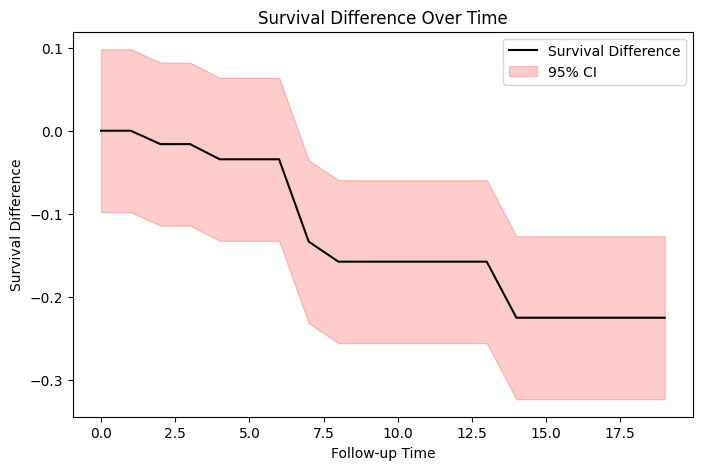

In [54]:
import matplotlib.pyplot as plt

# Extract values for plotting
time_steps = survival_data["period"].values
survival_probs = survival_data["survival_prob"].values

# Compute survival difference from baseline
survival_diff = survival_probs - survival_probs[0]

# Approximate confidence intervals (assuming normal approximation)
std_error = 0.05  # Example standard error (should be based on model output)
lower_ci = survival_diff - 1.96 * std_error
upper_ci = survival_diff + 1.96 * std_error

# Plot survival difference over time
plt.figure(figsize=(8, 5))
plt.plot(time_steps, survival_diff, label="Survival Difference", color="black")
plt.fill_between(time_steps, lower_ci, upper_ci, color='red', alpha=0.2, label="95% CI")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Survival Difference Over Time")
plt.legend()
plt.show()